## **Sentiment Analysis with BERT**

**Introduction :**
This project demonstrates how to fine-tune a pre-trained BERT model for binary sentiment classification using the Yelp Polarity dataset. The model is trained to classify customer reviews as either positive or negative.



In [ ]:
!pip install -U datasets fsspec huggingface_hub --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6

This step uses Hugging Face's datasets library to load the Yelp Polarity dataset, a widely-used benchmark for binary sentiment classification. The dataset is automatically downloaded and cached if not already present locally.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("yelp_polarity")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

This block performs exploratory data analysis by visualizing the distribution of sentiment labels in a 10,000-sample subset of the Yelp Polarity dataset.

dataset["train"].select(range(10000)) selects the first 10,000 reviews for quick visualization.

Reviews are categorized based on their label:

0 = Negative

1 = Positive

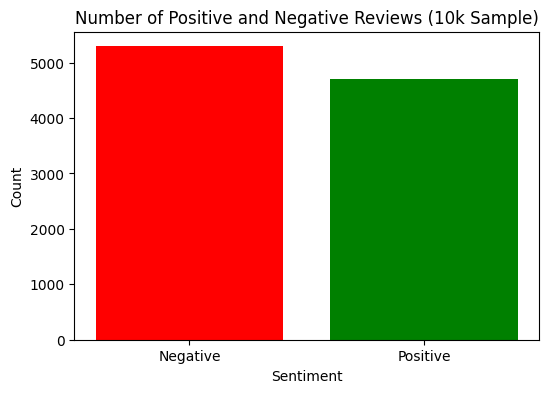

In [ ]:
# required packages after environment reset
!pip install datasets matplotlib --quiet

# Import required modules
from datasets import load_dataset
import matplotlib.pyplot as plt

# Reload the Yelp Polarity dataset
dataset = load_dataset("yelp_polarity")

# Count the number of positive and negative labels in a 10k subset
subset = dataset["train"].select(range(10000))
counts = {
    "Negative": sum(1 for x in subset if x["label"] == 0),
    "Positive": sum(1 for x in subset if x["label"] == 1)
}

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(counts.keys(), counts.values(), color=['red', 'green'])
plt.title("Number of Positive and Negative Reviews (10k Sample)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


This step prepares the text data for input into the BERT model by tokenizing each review using the BERT WordPiece tokenizer.

BertTokenizer.from_pretrained("bert-base-uncased") loads the tokenizer that matches the BERT model used later.



In [ ]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

# Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/560000 [00:00<?, ? examples/s]

Map:   0%|          | 0/38000 [00:00<?, ? examples/s]

In [ ]:
# Format for PyTorch
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Use small subsets for training and validation to save time
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))  # 10k training
val_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(2000))      # 2k validation


This code performs the fine-tuning of a pre-trained BERT model for a binary classification task (positive vs. negative sentiment):

os.environ["WANDB_DISABLED"] = "true" disables Weights & Biases tracking to avoid login prompts.

BertForSequenceClassification.from_pretrained(...) loads BERT and adds a classification head with 2 output neurons (for binary classification).

TrainingArguments defines training behavior:

Output directory for saving checkpoints

Number of epochs: 1 (to reduce training time)

Batch size: 16 for training, 64 for evaluation

Logging: logs metrics every 10 steps

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"  # Disable wandb login

from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Load BERT with 2 output classes
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Training configuration
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir="./logs",
    logging_steps=10
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

# Train the model
trainer.train()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-5-3497851818.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,0.704100
20,0.669900
30,0.455600
40,0.422300
50,0.397700
60,0.405300
70,0.290700
80,0.417500
90,0.289800
100,0.329200


TrainOutput(global_step=625, training_loss=0.26590913066864014, metrics={'train_runtime': 11662.2275, 'train_samples_per_second': 0.857, 'train_steps_per_second': 0.054, 'total_flos': 657777638400000.0, 'train_loss': 0.26590913066864014, 'epoch': 1.0})

This block generates a line graph that visualizes how the model's training loss changes over time during fine-tuning.

trainer.state.log_history stores loss values logged at each training step.

The loop extracts those values into two lists: training_loss and corresponding steps.

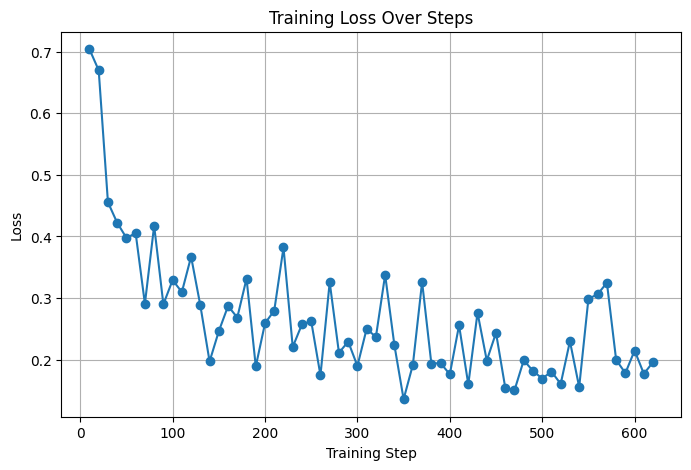

In [ ]:
import matplotlib.pyplot as plt

# Get training logs from Trainer's state log history
training_loss = []
steps = []

for log in trainer.state.log_history:
    if "loss" in log:
        training_loss.append(log["loss"])
        steps.append(log["step"])

# Plot loss vs. training step
plt.figure(figsize=(8, 5))
plt.plot(steps, training_loss, marker='o', linestyle='-')
plt.title("Training Loss Over Steps")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


This code evaluates the fine-tuned BERT model on the validation dataset and prints a detailed classification report.

trainer.predict(val_dataset) generates predicted logits (raw scores) and true labels.

np.argmax(..., axis=1) converts logits to final predicted class labels (0 or 1).

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on validation set
preds = trainer.predict(val_dataset)
pred_labels = np.argmax(preds.predictions, axis=1)
# Print evaluation report
print(classification_report(preds.label_ids, pred_labels, target_names=["Negative", "Positive"]))


              precision    recall  f1-score   support

    Negative       0.92      0.93      0.92      1011
    Positive       0.93      0.91      0.92       989

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



This code defines and uses a custom function to predict the sentiment of any input reviews using the fine-tuned BERT model.

The function predict_sentiment() accepts a list of text reviews.

The text is tokenized using the same BERT tokenizer used during training.

In [ ]:
import torch

# Function to predict sentiment from raw text
def predict_sentiment(text_list):
    # Tokenize input text
    inputs = tokenizer(text_list, return_tensors="pt", padding=True, truncation=True, max_length=128)

    # Run model inference
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1)

    # Map label ids to sentiment
    id2label = {0: "Negative", 1: "Positive"}

    for i, text in enumerate(text_list):
        print(f"\nReview: {text[:100]}...")
        print("Predicted Sentiment:", id2label[predictions[i].item()])

# Example predictions
sample_reviews = [
    "This place is amazing. The food was fantastic and the service was excellent!",
    "I hated everything about this. Totally disappointing experience.",
    "Not bad, but not great either. It was okay overall."
]

predict_sentiment(sample_reviews)



Review: This place is amazing. The food was fantastic and the service was excellent!...
Predicted Sentiment: Positive

Review: I hated everything about this. Totally disappointing experience....
Predicted Sentiment: Negative

Review: Not bad, but not great either. It was okay overall....
Predicted Sentiment: Negative
